In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xai-updatedataset/train_df (1).csv
/kaggle/input/xai-updatedataset/test_df (1).csv


In [3]:
!pip install language-tool-python
!pip install textstat

In [4]:
import numpy as np

import pandas as pd

from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from xgboost import XGBClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import KFold

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import classification_report



from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt

import torch

from sklearn.decomposition import PCA



import shap

import nltk

from nltk.tokenize import sent_tokenize



from transformers import BertTokenizer, BertModel



import textstat

import spacy

import language_tool_python

In [5]:
from scipy.sparse import hstack

import scipy.sparse as sp

In [6]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.5 MB/s eta 0:00:00:00:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Initialize the LanguageTool object for English

tool = language_tool_python.LanguageTool('en')

In [8]:
def vocalSize(sentence):
    # Tokenize with spaCy
    doc = nlp(sentence.lower())
    tokens = set([token.text for token in doc if not token.is_punct])
    # Get the vocabulary size
    vocab_size = len(tokens)
    return vocab_size

In [9]:
def sentence_complexity(sentence):
  flesch_score = textstat.flesch_reading_ease(sentence) # Flesch Reading Ease: Measures the readability of a sentence. Higher scores indicate easier readability.
  fk_grade_level = textstat.flesch_kincaid_grade(sentence) # Flesch-Kincaid Grade Level: Indicates the grade level required to understand the text. Higher scores mean more complex text.
  gunning_fog = textstat.gunning_fog(sentence) # Gunning Fog Index: Measures the readability of the text, considering sentence length and complex words (3+ syllables). Higher values indicate more complex text.
  smog_index = textstat.smog_index(sentence)  # SMOG Index: Estimates the years of education required to understand the text. Higher values indicate more complex text.
  composite_score = (flesch_score * 0.2 + fk_grade_level * 0.3 + gunning_fog * 0.3 + smog_index * 0.2)
  return composite_score

In [10]:
def grammatical_mistakes(sentence):
  mistakes = len(tool.check(sentence))
  return mistakes

In [14]:
train_path = "/kaggle/input/xai-updatedataset/train_df (1).csv"
test_path = "/kaggle/input/xai-updatedataset/test_df (1).csv"
train_df = pd.read_csv(train_path).sample(3000)
test_df = pd.read_csv(test_path).sample(100)

In [15]:
train_df.shape

(3000, 2)

In [16]:
train_df['vocab_size'] = train_df['text'].apply(vocalSize)
train_df['sentence_complexity'] = train_df['text'].apply(sentence_complexity)
train_df['grammatical_mistakes'] = train_df['text'].apply(grammatical_mistakes)

In [17]:
test_df['vocab_size'] = test_df['text'].apply(vocalSize)
test_df['sentence_complexity'] = test_df['text'].apply(sentence_complexity)
test_df['grammatical_mistakes'] = test_df['text'].apply(grammatical_mistakes)

## Training XGBoost Model

In [18]:
tfidf = TfidfVectorizer(max_features=25000)
X_tfidf = tfidf.fit_transform(train_df['text']).toarray()
y_train = train_df['label']

X_additional_features = train_df[['vocab_size', 'sentence_complexity', 'grammatical_mistakes']].to_numpy()

X_train = np.hstack((X_tfidf, X_additional_features))

# Initialize the classifier
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)

# Fit the model
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

ROC AUC Score: 1.0000
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        63
           1       1.00      0.97      0.99        37

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion Matrix:
 [[63  0]
 [ 1 36]]


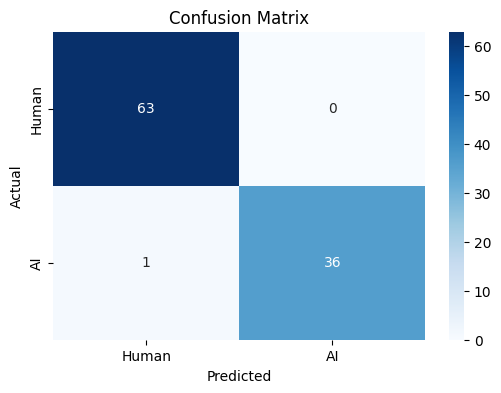

In [19]:
X_text_tfidf = tfidf.transform(test_df['text']).toarray()        # Transform testing text into TF-IDF features
y_test = test_df['label']

X_test_additional_features = test_df[['vocab_size', 'sentence_complexity', 'grammatical_mistakes']].to_numpy()

X_test = np.hstack((X_text_tfidf, X_test_additional_features))

# Predictions
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluation
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [30]:
def model_predict(X_test):
    return xgb_clf.predict(X_test)

## # Implementing SHAP

In [ ]:
test_df

In [21]:
explainer = shap.TreeExplainer(xgb_clf)

In [22]:
shap_values = explainer.shap_values(X_test)

In [39]:
def explain_prediction(text):
    """
    Predicts and explains the model's decision for a given text.
    """
    # Transform text into TF-IDF features
    text_transformed = tfidf.transform([text]).toarray()

    vocab_size = vocalSize(text)
    sentenceComplexity =  sentence_complexity(text)
    grammaticalMistakes = grammatical_mistakes(text)
    
    # Extract additional linguistic features
    additional_features = np.array([vocab_size, sentenceComplexity, grammaticalMistakes]).reshape(1, -1)
    
    # Combine TF-IDF and additional features
    X_test_combined = np.hstack((text_transformed, additional_features))

    # Make prediction
    prediction = model_predict(X_test_combined)[0]
    print(f"Prediction: {prediction}")
    print(f"Input Text: {text}")

    # Specify the indices of selected features
    selected_features = ['vocab_size', 'sentence_complexity', 'grammatical_mistakes']
    selected_indices = [len(tfidf.get_feature_names_out()) + i for i, _ in enumerate(selected_features)]
    
    # Generate SHAP explanation
    explanation = Explanation(
        values=shap_values[0][selected_indices],  # Use first sample for now
        base_values=explainer.expected_value,  # Base value from explainer
        data=X_test_combined[0, selected_indices],  # Feature values
        feature_names=selected_features  # Selected feature names
    )

    # Plot SHAP explanation
    shap.plots.bar(explanation)

Actual Label: 1
Prediction: 1
Input Text: The World Trade Center catastrophy was a terrible event that occurred on September 11, 2001, when two planes break_apart into the Twin Towers of the World Trade Center in New York City. The towers collapsed, causing the deaths of thousands of people and devastating the city. Some people believe that this event was not just a tragic accident, but rather a conspiracy, or a secret plan made by a group of people to do something harmful or illegal. There are many different theories about who was behind the conspiracy and what their motivations might have been. Some people believe that the U.S. government or other powerful organizations were involved in the attacks in order to further their own goals or agendas. Others believe that the attacks were carried out by terrorists or other groups who wanted to cause harm to the U.S. or to Western civilization more generally. It is important to note that there is no credible evidence to support these conspir

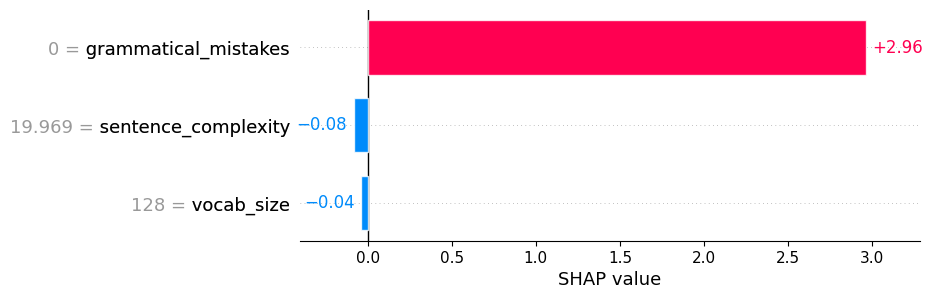

In [40]:
i=0
print(f"Actual Label: {test_df.iloc[i]['label']}")
explain_prediction(test_df.iloc[i]['text'])

Actual Label: 0
Prediction: 0
Input Text: Since all life we know requires water , if we went looking for life that did n't require water , we 'd have no idea what to look for . Since water is a prerequisite for Earth - life , it 's a better justification for focusing a search than just trying to search everywhere . > is nt it possible that life could evolve via other mechanisms instead of just DNA , or without needing water ? Possibly . But we have no idea what those mechanism might be , or if such mechanisms even exist , so we have no way of knowing where to look to find such life . Thus it makes sense to focus on the criteria that are necessary for the only type of life we 're aware of , because at least we have some precedent for it . It 's not so much that they are sure , as the fact that water is a straight up amazing molecule and it 's perfect for pretty much everything that you would need for life . On top of that it 's composed of some of the most common elements in the univers

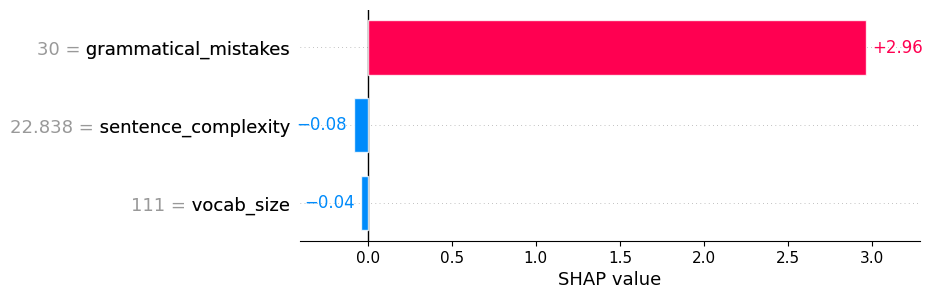

In [41]:
i=2
print(f"Actual Label: {test_df.iloc[i]['label']}")
explain_prediction(test_df.iloc[i]['text'])